#  Regressione Logistica e Ricerca di Particelle Supersimmetriche #


In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Informazioni

scopo: imparare a risolvere un problema di classificazioen tramite un classificatore lineare di regressione logistica, prendere dimestichezza con la libreria scikit-learn e imparare l'uso del package Pandas per la gestione di dataset complessi

campione di esempi: [SUSY dataset](https://archive.ics.uci.edu/ml/datasets/SUSY) da [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

Ci focalizzermeo in una task di classificazione binaria (segnale (SUSY) - fondo (processi del Modello Standard con stessi stati finali di quelli prodotti nei decadimenti delle particelle supersimmetriche)).


**Regressione logistica**

È una dei modelli classici del ML per la classificazione che permette di introdurre la maggior parte delle idee e techniche del ML supervisionato. 

Ogni set di fatures $\mathbf{x}_i$ è associato ad una label di categoria (classe)$C_i\in\{1,0\}$, con $i=1\ldots n$.
Di seguito il feature vector $\mathbf{x}_i$ è ridefinito via the augmented rapresentation $\mathbf{x}\rightarrow (1,\mathbf{x})$. 
La likelihood function della regressione logistica è data dalla funzione sigmoide:

$$
P(c_i=1)=1-P(c_i=0)= {1 \over 1+ e^{-\mathbf{w}\cdot \mathbf{x}_i}},
$$

in cui $\mathbf{w}$ sono i pesi che definiscono il modello di regressione logistica e che vengono scelti massimizzando la log-likelihood sul campione di dati di training. 

Definendo la funzione:
$$
f(a)={1 \over 1+ e^{-a}},
$$

con derivata rispetto a $a$:
$$
{df \over da}= f(1-f).
$$

e definendo $f_i \equiv f(\mathbf{w}\cdot \mathbf{x}_i)$, possiamo esprimere la likelihood dei dati $\{ \mathbf{x}_i, C_i \}$ come:

$$
P(Data|\mathbf{x})= \prod_{i=1}^n f_i^{C_i}(1-f_i)^{1-C_i}
$$

con log-likelihood:
$$
\log{P(Data|\mathbf{w})}= \sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i)
$$

La log-likelihood cambiata di segno fornisce la loss function ed è chiamata cross-entropy error function:
$$
\mathrm{Cross\,Entropy}=E(\mathbf{w})= -\sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i).
$$

Osserviamo che:
$$
\nabla E(\mathbf{w})=\sum_{i=1}^n (f_i-C_i)\mathbf{x}_i.
$$

cioè il gradiente punta nella direzione della somma delle direzioni dei vettori del training set pesata con la differenza tra la label vera e la probabilità di predire la label stessa.

La stima di massima verosimiglianza (MLE) corrisponde alla minimizzazione della cross-entropia. Questo può essere fatto usando metodi di discesa lungo il gradiente.

### Passo 1: carica il dataset con pandas

**informazioni sul dataset:**

>Provide all relevant informatioThe data has been produced using Monte Carlo simulations. The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes.

* data format: The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features):: lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1). For detailed information about each feature see the original paper.


* reference: <cite> P. Baldi, P. Sadowski, and D. Whiteson. "Searching for Exotic Particles in High-energy Physics with Deep Learning." Nature Communications 5 (July 2, 2014)</cite>.

Il campione che potete scaricare da qui [Campione SUSY.csv 1M eventi](https://www.dropbox.com/s/qfvjlrdz38goien/SUSY.csv?dl=0) contiene solo 1M degli 11M di eventi del dataset totale (per mantenere la size limitata).

Importiamo il dataset cono pandas usando i primi 950k eventi come training set e i secondi 50k come test set.

In [0]:
# Importing the SUSY Data set
import pandas as pd

import numpy as np
import warnings
#se non si vogliono ricevere warning scommentare questa riga
#warnings.filterwarnings('ignore') 


seed=12345
np.random.seed(seed) #inizializza il randomizzatore

# Download SUSY.csv 
filename="/content/drive/My Drive/Colab Notebooks/dataset/SUSY.csv"
#filename=sample_data/SUSY.csv' 

columns=["signal",
         "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", 
         "lepton 2 pT", "lepton 2 eta", "lepton 2 phi",
         "missing energy magnitude","missing energy phi", "MET_rel",
         "axial MET", "M_R","M_TR_2",
         "R", "MT2", "S_R",
         "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 950k rows as train data, 50k as test data

#campione usato per training
df_train=pd.read_csv(filename,names=columns,nrows=950000,
                     engine='python') 

#campione per test
df_test=pd.read_csv(filename,names=columns,nrows=50000, 
                    skiprows=950000,engine='python') 

**Definizione funzioni utili in pandas:**

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
#accede in pandas ai dati del campione di training e li formatta in modo comodo
def getData(df,nVar): #estarzione segnale e features da 1 a nVar
  x=df.iloc[:,1:nVar].values
  y=df.iloc[:,0].values
  return(x,y)
# usa pandas per costruire curve pseudo-ROC

def build_roc_curve(probs, signal_bit, threshes):
    # Convert things to a pandas series to build a DataFrame
    # which will make ROC curve logic easier to express
    signal_probs = pd.Series(probs[:,1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        # define acceptance
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        # sum over data frame with slicing conditions
        nSigCor = len(signal_df[(signal_df['accept']) & 
                                (signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[ (signal_df['sig_true']==0.) & 
                                (~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig) # False positive rate
        Rejection.append(nBkgCor/nBkg) # True positive rate

    return Acceptance, Rejection

### Passo 2:  Training  del modello lineare tipo logistic regression con scikit-learn

**definizione dei modelli:**
Stochastich Gradient Descent Classifier:
- loss: metodo impiegato
- Penalty: termine regolarizzatore
- toll: soglia di tolleranza (di base $10^{-3}$)
- predict_proba: la probabilità di appartenenza a una classe; meglio normalizzare i dati di partenza. Da usare con 'log'


In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

#logistic discriminant con regolarizzazione L2
def runSciKitRegressionL2(nVar, alpha,df_train,df_test):
    X_train, y_train = getData(df_train,nVar)
    X_test, y_test = getData(df_test,nVar)
    clf = SGDClassifier(loss="log", penalty="l2",alpha=alpha,
                        max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel()) #classificazione del modello
    predictions = clf.predict(X_test) #predizione dopo apprendimento
    print('Accuracy on test data with alpha %.2E : %.3f' %(
        alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test) #si usa solo con loss

    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs, Acceptance, Rejection)

#logistic discriminant con regolarizzazione L1
def runSciKitRegressionL1(nVar,alpha,df_train,df_test):
    X_train, y_train = getData(df_train,nVar)
    X_test, y_test = getData(df_test,nVar)
    clf = SGDClassifier(loss="log", penalty="l1",alpha=alpha,
                        max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(
        alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)

    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs,Acceptance,Rejection)

**Training e valutazione del modello con regolarizzazione L1**

* usiamo inizialmente solo le prime 8 feature (low-level)
* $\alpha$ parametro che definisce il peso del termine di regolarizzazione e che va scelto in modo da missimizzare le prestazioni


In [0]:
alphas = np.logspace(-10,1,11) #spaziamento logaritmico da potenza -10 a 1 11 valori

Accuracy on test data with alpha 1.00E-10 : 0.663
Accuracy on test data with alpha 1.26E-09 : 0.651
Accuracy on test data with alpha 1.58E-08 : 0.756
Accuracy on test data with alpha 2.00E-07 : 0.751
Accuracy on test data with alpha 2.51E-06 : 0.722
Accuracy on test data with alpha 3.16E-05 : 0.768
Accuracy on test data with alpha 3.98E-04 : 0.769
Accuracy on test data with alpha 5.01E-03 : 0.768
Accuracy on test data with alpha 6.31E-02 : 0.749
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.542


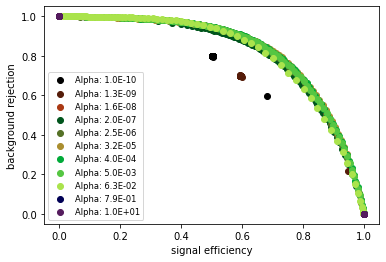

In [0]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    #variabili usate e alpha
    probs,accept,rej = runSciKitRegressionL1(8,alpha,df_train,df_test) 
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

**Osservazioni:**

Abbiamo ottenuto un accuracy del 77% che è già piuttosto buona per un'analisi di questo tipo. Tramite la curva pseudo-ROC il fisico delle particelle può decidere il punto ottimale di lavoro per la data analisi (i.e. la condizione efficienza segnale vs reieizione fondo che ottimizza per esempio la sensibilità di scoperta).

Notiamo anche che i risultati sono sensibili al peso della regolarizzazione $\alpha$. In particolare i risultati delle punti della curva a peggiori prestazioni (verde scuro) indicano che in questi casi il modello non è in grado di distinguere tra le due classi. 

Ci aspettiamo che questo succeda per valori di $\alpha$ più grandi, perchè la regolarizzazione L1 effttivamente tende a "spegnere" la maggior parte delle osservabili (costringe i pesi ad essere vicini a zero), di conseguenza la classificazione risulta in effetti nel tracciare una superficie nella distribuzione di pochissime (probabilmente una sola) fetaure in input, classificando gli eventi di segnale quelli da una pate della superficie e di fondo quelli dall'altra.

Per verificarlo plottiamo la probabilità di segnale e fondo ricostruite dal modello per il caso di $\alpha$ ottimale ($\alpha = 3.98\ 10^{-4}$) e per il caso peggiore ($\alpha = 0.79$):

Accuracy on test data with alpha 3.98E-04 : 0.768


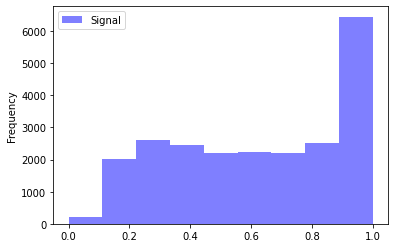

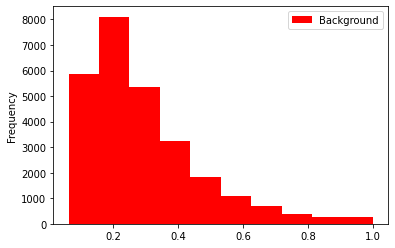

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,3.98e-4,df_train,df_test) 
Signal = df_test.iloc[:,0:1] 

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,
                     bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 7.90E-01 : 0.542


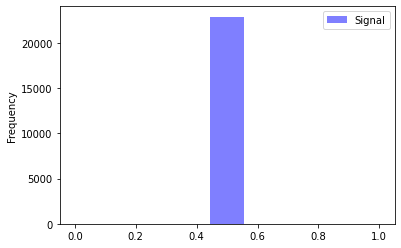

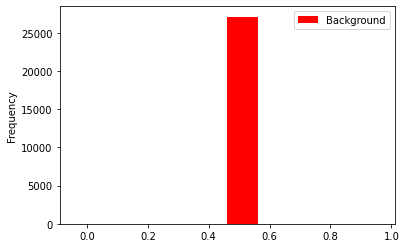

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,0.79,df_train,df_test)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,
                     bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

### Ottimizziamo ora usando tutte e 18 le osservabili ... ###

Accuracy on test data with alpha 1.00E-10 : 0.722
Accuracy on test data with alpha 1.26E-09 : 0.689
Accuracy on test data with alpha 1.58E-08 : 0.594
Accuracy on test data with alpha 2.00E-07 : 0.747
Accuracy on test data with alpha 2.51E-06 : 0.755
Accuracy on test data with alpha 3.16E-05 : 0.789
Accuracy on test data with alpha 3.98E-04 : 0.789
Accuracy on test data with alpha 5.01E-03 : 0.785
Accuracy on test data with alpha 6.31E-02 : 0.749
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.458


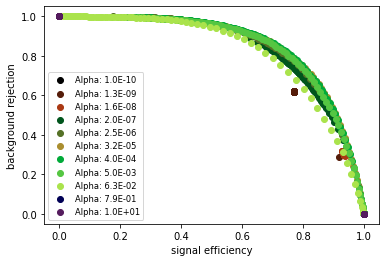

In [0]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha,df_train,df_test)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.787


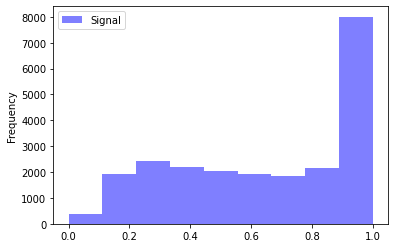

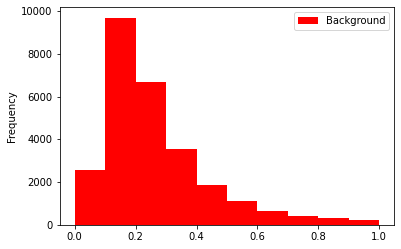

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(18,3.98e-4)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,
                     bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

abbiamo migliorato l'accuracy che ora è del 79% e, come atteso dall'usare più features, è diminuita la dipedenza dalla regolarizzazione...

<b> Esercizi:</b>

* provare ad usare la regolarizzazione L2, i risultati migliorano?

* provare a addestrare il modello dopo aver normalizzato i dati in input in modo che abbiano simile dinamica, i risultati cambiano? (è obbligatorio per le reti neurali)


* provare ad usare dei tagli rettangolari sulle osservabili migliori. Calcolate le prestaizoni in termini di efficienza e reiezione e confrontate con la ROC curva ottenuta con la regressione logistica ... 

* provate a pensare se sia possibile selezionare una regione del campione dei dati di training che permetta di migliorare le prestazioni (suggerimento: pensare a dove il guadagano dall'uso del ML ha più valore rispetto ad una analisi tradizionale cut-based).

***
***
### Esercizio da svolgere
#### Uso di L2
Inseriamo come penalità L2 e osserviamo le differenze con il caso di L1 sia con 8 variabili che tutte.<br>
Usando 8 variabili la migliore efficienza è raggiunta per $\alpha=  3.98\ 10^{-04}$ ed equivale a un'efficienza di 0.769; mentre il caso peggiore si ha per $\alpha$=0.794 ed equivale a  0.69</br>
Adottando tutte le features per lo stesso valore di $\alpha$ ottimale registriamo un'efficienza di 0.790 e per lo stesso valore pessimale 0.731.</br>
Paragonando i risultati con quelli precedenti si registra il seguente fatto:
1. I valori che massimizzano l'efficienza sono gli stessi.
2. L'uso di tutte le features restituisce nel caso della penalità $L2$ un valore maggiore rispetto all'uso di $L1$.
3. Varia la pendenza della curva ROC e diminuisce per $L2$

Accuracy on test data with alpha 1.00E-10 : 0.709
Accuracy on test data with alpha 1.26E-09 : 0.716
Accuracy on test data with alpha 1.58E-08 : 0.616
Accuracy on test data with alpha 2.00E-07 : 0.692
Accuracy on test data with alpha 2.51E-06 : 0.715
Accuracy on test data with alpha 3.16E-05 : 0.763
Accuracy on test data with alpha 3.98E-04 : 0.769
Accuracy on test data with alpha 5.01E-03 : 0.769
Accuracy on test data with alpha 6.31E-02 : 0.758
Accuracy on test data with alpha 7.94E-01 : 0.699
Accuracy on test data with alpha 1.00E+01 : 0.458


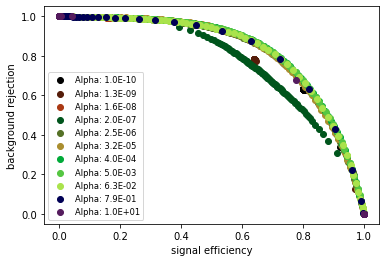

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(8,alpha,df_train,df_test) 
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 1.00E-10 : 0.649
Accuracy on test data with alpha 1.26E-09 : 0.767
Accuracy on test data with alpha 1.58E-08 : 0.701
Accuracy on test data with alpha 2.00E-07 : 0.713
Accuracy on test data with alpha 2.51E-06 : 0.739
Accuracy on test data with alpha 3.16E-05 : 0.789
Accuracy on test data with alpha 3.98E-04 : 0.790
Accuracy on test data with alpha 5.01E-03 : 0.784
Accuracy on test data with alpha 6.31E-02 : 0.759
Accuracy on test data with alpha 7.94E-01 : 0.726
Accuracy on test data with alpha 1.00E+01 : 0.458


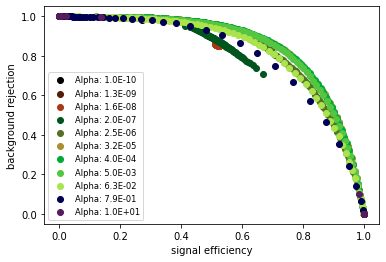

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(18,alpha,df_train,df_test) 
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

### Normalizzazione dei dati
Si analizza l'efficienza dell'algoritmo procendendo con una normalizzazione dei dati. La normalizzazione viene imputata a due funzioni in `sklearn.preprocessing`: <b> MinMaxScaler</b> e <b>normalize</b> e 
</br>
Per ogni normalizzazione vengono riportati gli istogrammi dei dati per ciascuna features, la creazione della curva ROC utilizzando come penalty $L2$ e 18 features e la probabilità utilizzando il valore ottimale.

#### `MinMaxScaler`
Questa funzione definisce i dati tra 0 e 1 lasciando inalterata la shape.</br>
Si vede che la dinamica ottimale si ha per $\alpha=2.51\ 10^{-06}$ con una efficienza di  0.783
Si registra un aumento sensibile della efficienza e anche un cambiamento del valore ottimale di $\alpha$</br>
La probabilità separa perfettamente il segnale con il fondo come in assenza della normalizzazione.

#### `Normalize`
In questo caso si osserva un miglioramento ancor più sensibile rispetto al caso senza normalizzazione: in corrispondenza di $\alpha=3.16\ 10^{-05}$ l'efficienza registrata è 0.791.<br>
Il grafico della probabilità mostra che la separazione tra i due segnali è meno maraca per la zona centrale, imputabile alla manipolazione dei dati.


In [0]:
##normalizzazione dei dati
#normalizza tra 0 e 1 
from sklearn.preprocessing import MinMaxScaler 

#normalizza a una gaussiana con media nulla e varianza 1
from sklearn.preprocessing import normalize 
scaler=MinMaxScaler()

def multist(df,tl=None): #permette di plottare l'istogramma di tutte le features
  fig=plt.figure(figsize=(30,20))
  fig.suptitle(tl,fontsize=50)
  ncol=len(columns)
  for i in range(1,ncol):
    ax=fig.add_subplot(ncol//6,6,i)
    ax.hist(df.iloc[:,i].values)

In [0]:
#creazione dati per studio normalizzazione tra 0 e 1 
df_test_0=df_test.copy()
df_train_0=df_train.copy()
df_test_0[columns[1:]]=scaler.fit_transform(df_test[columns[1:]].values)
df_train_0[columns[1:]]=scaler.fit_transform(df_train[columns[1:]].values)

In [0]:
#creazione dati per studio normalizzazione in maniera gaussiana 
df_test_n=df_test.copy()
df_train_n=df_train.copy()
df_test_n[columns[1:]]=normalize(df_test[columns[1:]].values)
df_train_n[columns[1:]]=normalize(df_train[columns[1:]].values)

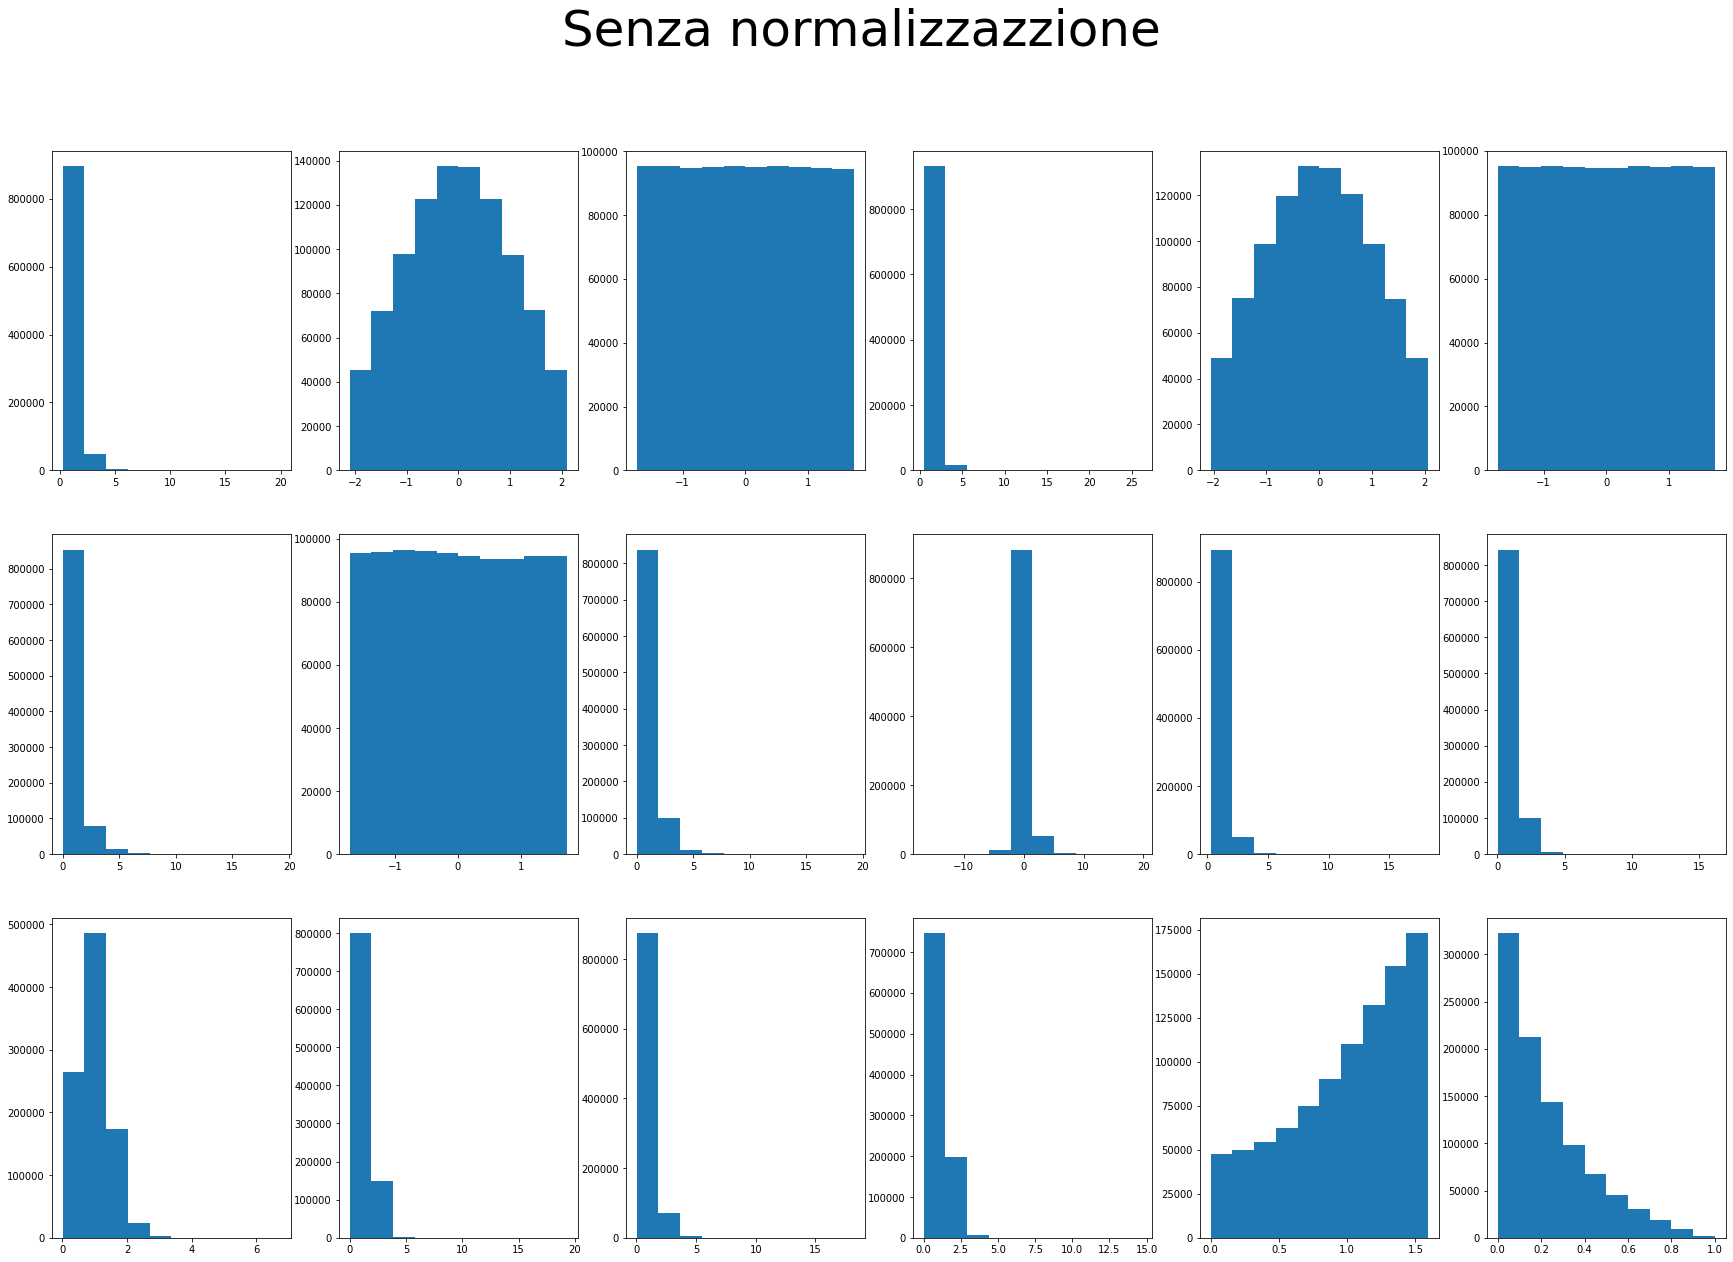

In [0]:
# istogramma dei dati senza normalizzazione 
plt.close()
multist(df_train,'Senza normalizzazzione')

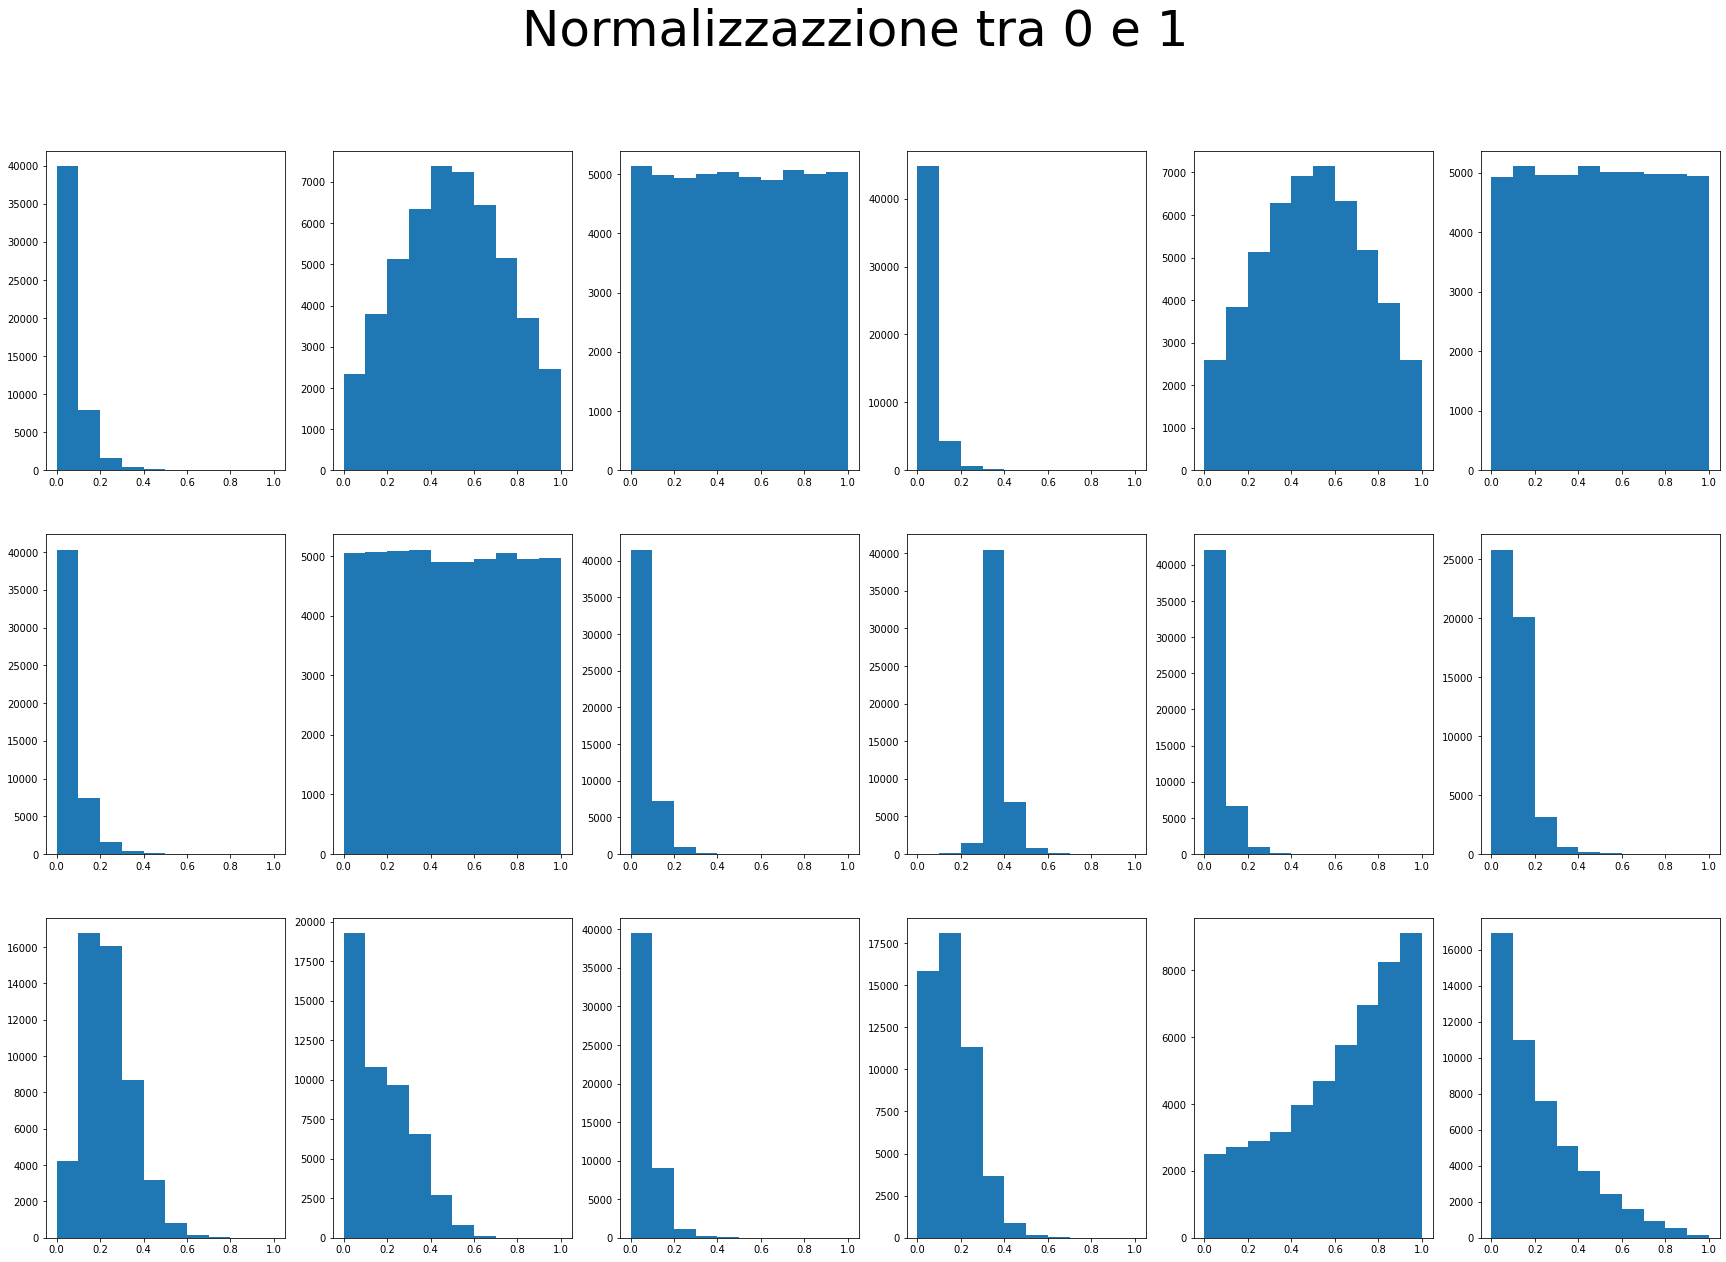

In [0]:
plt.close()
multist(df_test_0,'Normalizzazzione tra 0 e 1')

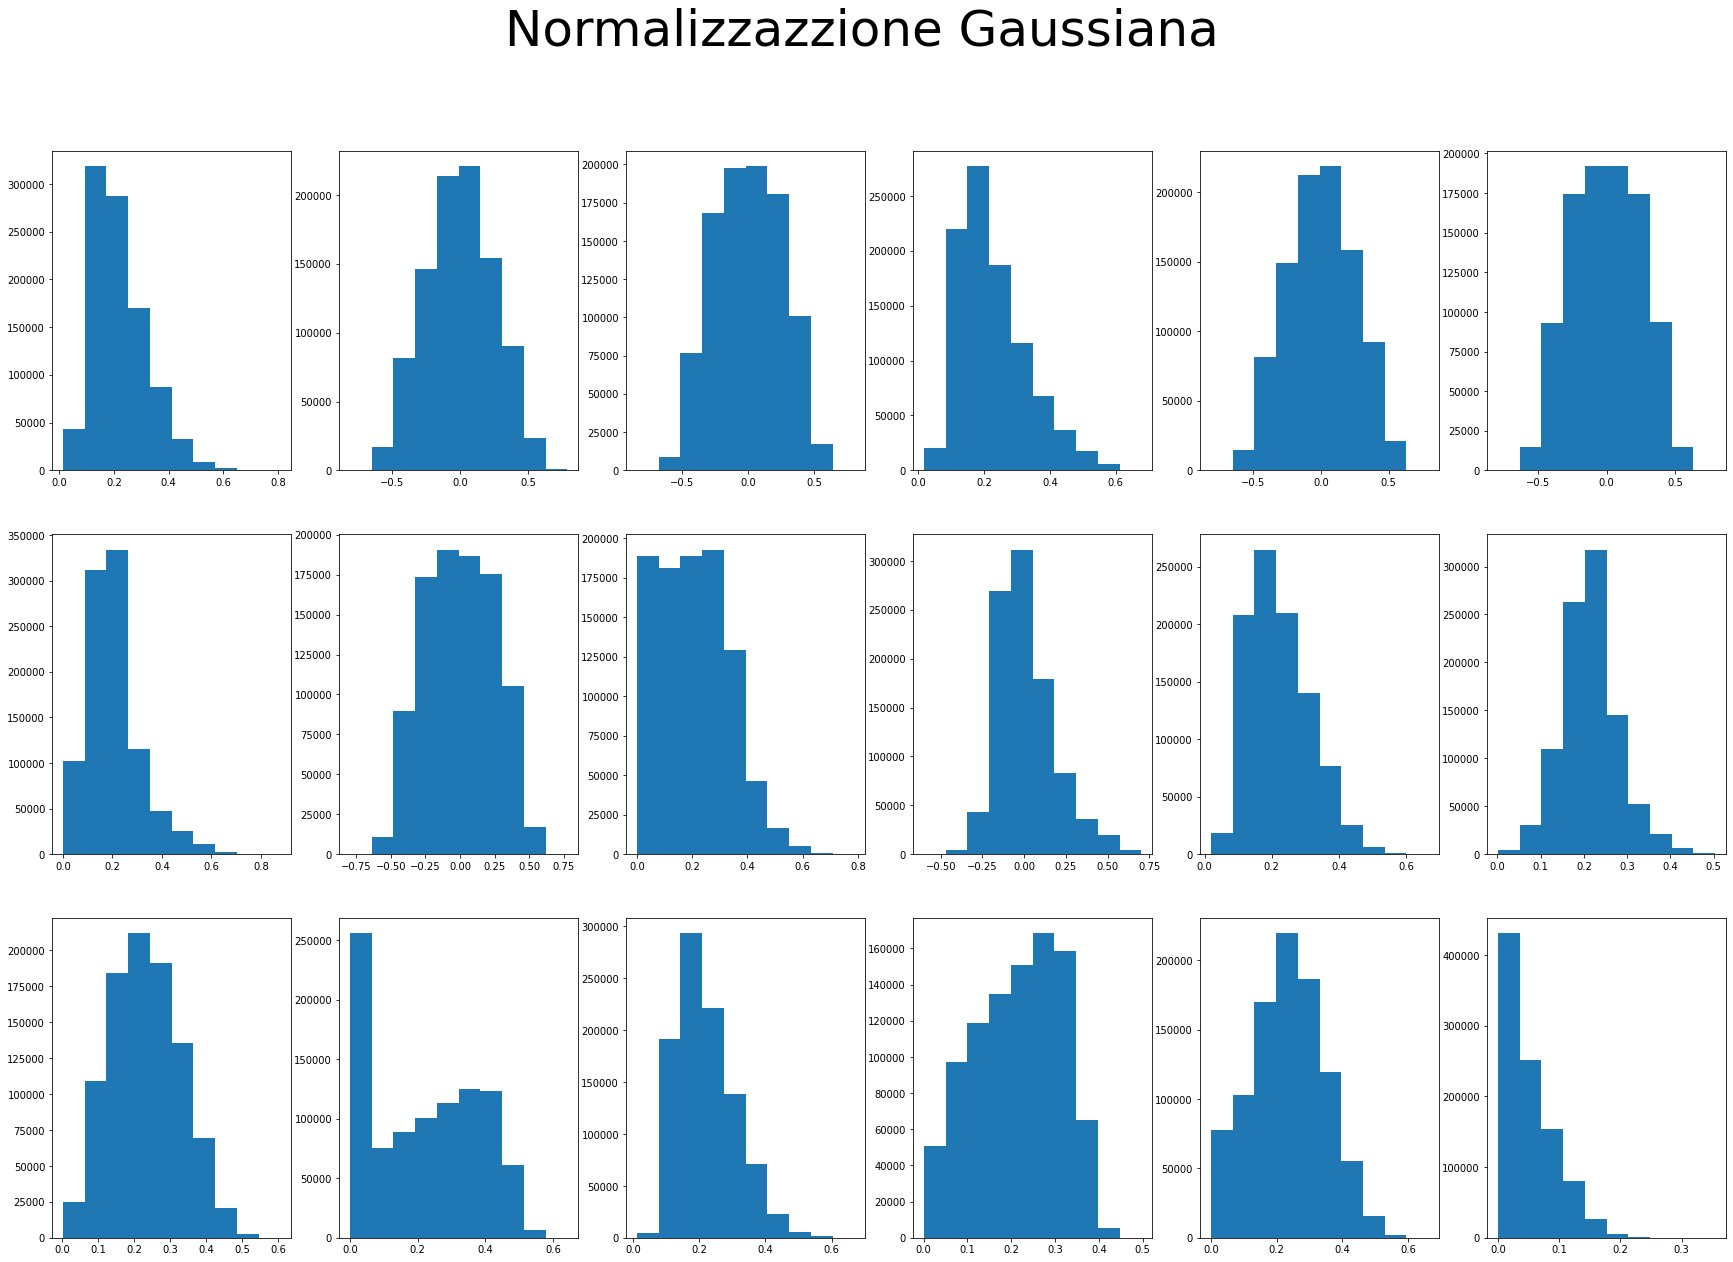

In [0]:
plt.close()
multist(df_train_n,'Normalizzazzione Gaussiana')

Accuracy on test data with alpha 1.00E-10 : 0.780
Accuracy on test data with alpha 1.26E-09 : 0.728
Accuracy on test data with alpha 1.58E-08 : 0.550
Accuracy on test data with alpha 2.00E-07 : 0.731
Accuracy on test data with alpha 2.51E-06 : 0.783
Accuracy on test data with alpha 3.16E-05 : 0.781
Accuracy on test data with alpha 3.98E-04 : 0.778
Accuracy on test data with alpha 5.01E-03 : 0.731
Accuracy on test data with alpha 6.31E-02 : 0.542
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.458


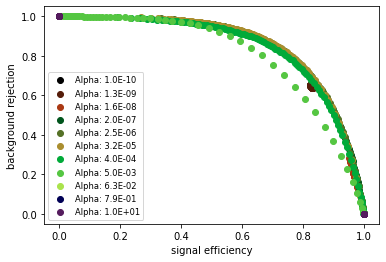

In [0]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha,df_train_0,df_test_0) 
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 2.51E-06 : 0.785


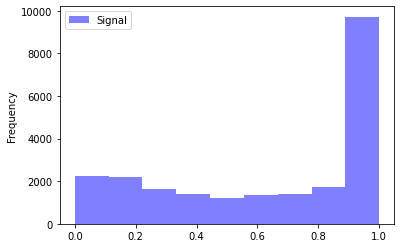

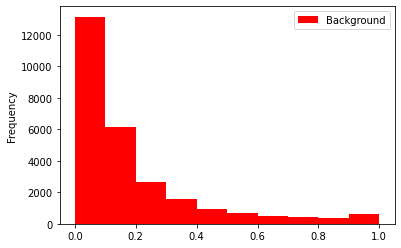

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(18,2.51e-06,df_train_0,df_test_0)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,
                     bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E-10 : 0.757
Accuracy on test data with alpha 1.26E-09 : 0.731
Accuracy on test data with alpha 1.58E-08 : 0.770
Accuracy on test data with alpha 2.00E-07 : 0.657
Accuracy on test data with alpha 2.51E-06 : 0.791
Accuracy on test data with alpha 3.16E-05 : 0.792
Accuracy on test data with alpha 3.98E-04 : 0.786
Accuracy on test data with alpha 5.01E-03 : 0.765
Accuracy on test data with alpha 6.31E-02 : 0.570
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.542


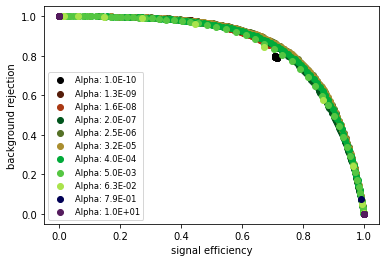

In [0]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(18,alpha,df_train_n,df_test_n) 
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.16E-05 : 0.792


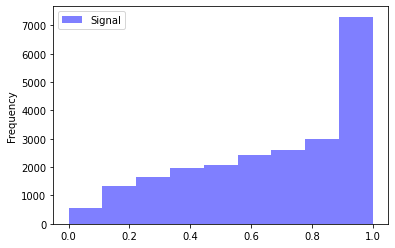

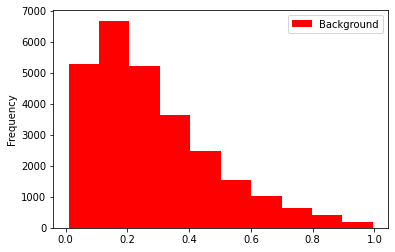

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL2(18,3.16e-05,df_train_n,df_test_n)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,
                     bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

#### Tagli rettangolari
Per tagli rettangolari si intende la stima dell'accuracy fatte attraverso un metodo rozzo quale la scelta di opportune features e la successiva identificazione attraverso una disuguaglainza.<br>
Scorrendo attraverso tutte le features, si ricercano quei valori tali che assegnando ai dati maggiori o minori di quella variabile si abbia un accuracy migliore. Si visualizza graficamente quello che è successo: la linea verticale indica il valore per cui compiere il taglio. In presenza di dati in cui l'istogramma dei dati con segnale e senza è molto simile la cosa migliore è praticamente non compiere alcun taglio in quanto i segnali 1 sono maggiori di quelli 0 quindi si cerca in questi casi di massimizzare i *veri positivi*. Quando invece ci sono delle discrepanze abbastanza evidenti allora si può compiere un taglio più diretto di modo da massimizzare i *veri negativi* cercando di non diminuire eccessivamente i *veri positivi*.<br>
Si combinano quindi i tagli utilizzando le due variabili e si ottiene un'accuracy pari a 0.72. Viene quindi data una rappresentazione grafica dei tagli nello scatter plot e si mostra l'istogramma dei dati combinati associati alle features utilizzate. Come si vede la maggior parte dei dati è contenuta all'interno di una singola regione e i tagli puntano a inglobare tale zona.<br>
Si procede quindi con una predizione dei dati utilizzando come criterio il taglio identificato ossia `lepton1_pT>=0.255507` e `missing energy magnitude>=0.961009`. In questo caso l'accuracy ottenuta è pari a 0.72. Confrontando tale valore con quelli dedotti precedentemente si osserva che l'accuracy è minore rispetto ai metodi di ML. Questo è imputabile al numero di variabili utilizzate, che è minore rispetto agli algoritmi di ML, inoltre il ML permette anche di identificare le eventuali correlazioni non lineari, cosa che i tagli rettangolari non permettono di fare. 

Si implementano i tagli rettangolari utilizzando degli alberi: attarverso `sklearn.tree.DecisionTreeClassifier` si costruiscono per ciascuna feature, un albero con profondità pari a 1 e numero di foglie pari a 2, obbligando quindi l'algoritmo a compiere un solo taglio. Si riportano quindi i valori dei tagli e lo score dell'algoritmo quindi una rappresentazione grafica dell'albero stesso per ciascuna features. Come per l'algoritmo 'manuale' le features con maggiore potere risolutivo sono `M_TR_2` e `missing energy magnitude` sebbene il valore di soglia sia differente. Si osserva anche che per quelle features con accuracy bassa, un albero del genere non ha la possibilità di distinguere il segnale e assegna alle foglie la stessa label , 'Segnale=0' .<br>
In analogia con quanto fatto prima, si combinano le due features con accuracy maggiore. In questo caso i valori dei tagli sono in corrispondenza di, rispettivamente per M_TR_2 e missing energy magnitude, a 1.194076 e a 1.071069. L'accuracy così ottenuta è pari a 0.742. Come si vede questo valore è superiore del 2% rispetto al taglio 'manuale' .<br>
Si compie quindi una predizione utilizzando l'algoritmo così addestrato e si ha un'accuracy pari a 0.758. Il valore è maggiore rispetto al metodo manuale e si può imputare alla scelta delle diverse features e all'algoritmo utilizzato: sebbene siano state imposte delle restrizioni alla costruzione dell'albero, tuttavia questo riesce ad analizzare in maniera migliore di un banale ciclo for i dati della feature scelta per massimizzare l'accuracy.

In [0]:
#Plot degli istogrammi
def sigist(df1,df2,cut,accu):
  fig=plt.figure(figsize=(20,20))
  for i in range(1,len(columns)):
    ax1=fig.add_subplot(6,3,i)
    ax1.hist(df1.iloc[:,i].values,alpha=0.2,color='green',label='Segnale=0')
    ax1.hist(df2.iloc[:,i].values,color='red',alpha=0.2,label='Segnale=1')
    ax1.axvline(cut[i-1])
    ax1.set(title='Accuracy=%f'%accu[i-1])
    ax1.legend()

In [7]:
variabili=columns[1:].copy()
nstep = 20
ALL = df_train['signal'].count()
cut_maxs=[]
acc_maxs=[]
for nome in (variabili):
    print('Variable: ', nome)
    vmax = df_train[nome].max()
    vmin = df_train[nome].min()
    #print('min / max: %f / %f' %(vmin, vmax))
    delta = (vmax-vmin)/nstep
    acc_gt_max = -np.infty
    cut_gt_max = -np.infty
    acc_lt_max = -np.infty
    cut_lt_max = -np.infty
    for i in range(nstep):
        cut = vmin + delta*i
        data_sel_gt = df_train.loc[df_train[nome] >= cut]
        data_sel_lt = df_train.loc[df_train[nome] < cut]
        TP_gt = (data_sel_gt['signal'].loc[data_sel_gt['signal'] > 0.5]
                 ).count()
        TN_gt = (data_sel_lt['signal'].loc[data_sel_lt['signal'] < 0.5]
                 ).count()
        TP_lt = (data_sel_lt['signal'].loc[data_sel_lt['signal'] > 0.5]
                 ).count()
        TN_lt = (data_sel_gt['signal'].loc[data_sel_gt['signal'] < 0.5]
                 ).count()
        acc_gt = (TP_gt + TN_gt)/ALL
        acc_lt = (TP_lt + TN_lt)/ALL
        if acc_gt >= acc_gt_max:
           acc_gt_max = acc_gt
           cut_gt_max = cut
        if acc_lt >= acc_lt_max:
           acc_lt_max = acc_lt
           cut_lt_max = cut   
    if (acc_gt_max >= acc_lt_max):
        print('best cut: >%f / accuracy %f' %(cut_gt_max, acc_gt_max))
        acc_maxs+=[acc_gt_max]
        cut_maxs+=[cut_gt_max]
    else:
        print('best cut: <%f / accuracy %f' %(cut_lt_max, acc_lt_max))      
        cut_maxs+=[cut_lt_max]
        acc_maxs+=[acc_lt_max]

Variable:  lepton 1 pT
best cut: >1.240213 / accuracy 0.678025
Variable:  lepton 1 eta
best cut: <-2.102919 / accuracy 0.542066
Variable:  lepton 1 phi
best cut: <-1.734789 / accuracy 0.542066
Variable:  lepton 2 pT
best cut: >1.712696 / accuracy 0.580512
Variable:  lepton 2 eta
best cut: <-2.059306 / accuracy 0.542066
Variable:  lepton 2 phi
best cut: <-1.734202 / accuracy 0.542066
Variable:  missing energy magnitude
best cut: >0.961009 / accuracy 0.721126
Variable:  missing energy phi
best cut: <-1.727112 / accuracy 0.542066
Variable:  MET_rel
best cut: >1.924238 / accuracy 0.624680
Variable:  axial MET
best cut: >1.436781 / accuracy 0.599152
Variable:  M_R
best cut: >1.163800 / accuracy 0.630276
Variable:  M_TR_2
best cut: >0.815813 / accuracy 0.669620
Variable:  R
best cut: >1.354843 / accuracy 0.552324
Variable:  MT2
best cut: >1.930730 / accuracy 0.582987
Variable:  S_R
best cut: >0.937375 / accuracy 0.650435
Variable:  M_Delta_R
best cut: >1.467068 / accuracy 0.622139
Variable: 

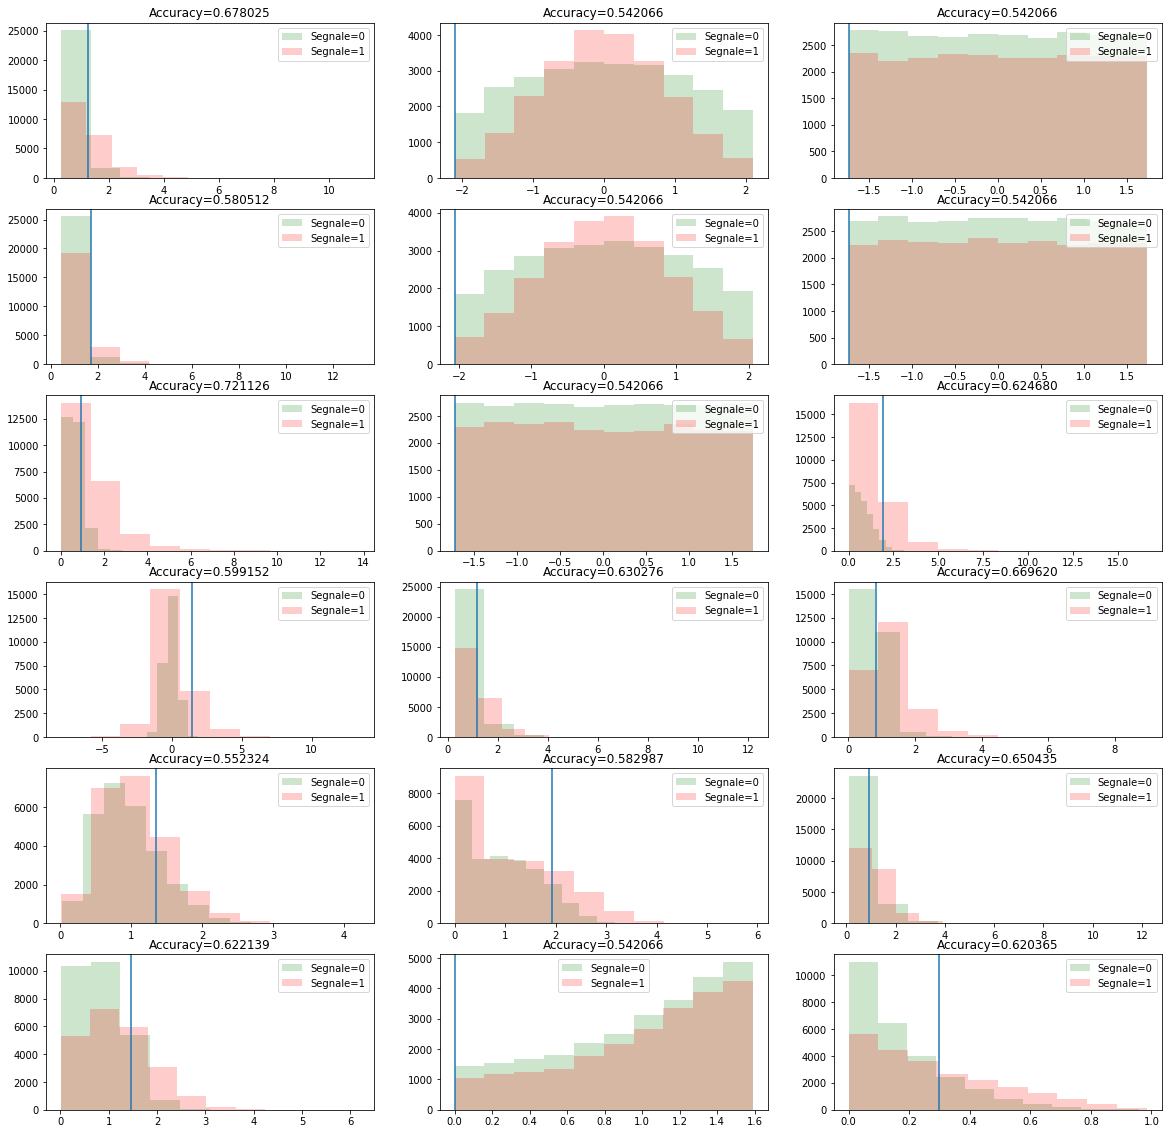

In [8]:
plt.close()
sig_train=df_train.iloc[:,0].values==1
sig_test=df_test.iloc[:,0].values==1
sigist(df_test.iloc[~sig_test,:],df_test.iloc[sig_test,:],cut_maxs,acc_maxs)

In [9]:
#nota è una ricerca easustiva a grid con loop 20x20 
 #scala molto male con la dimensione e il numero di step!

var_1 = 'lepton 1 pT'
var_2 = 'missing energy magnitude'

vmax_1 = df_train[var_1].max()
vmin_1 = df_train[var_1].min()
delta_1 = (vmax_1-vmin_1)/nstep

vmax_2 = df_train[var_2].max()
vmin_2 = df_train[var_2].min()
delta_2 = (vmax_2-vmin_2)/nstep

acc_max = -np.infty
cut_1_max = -np.infty
cut_2_max = -np.infty
total_steps = nstep*nstep
step = 0
for i in range(nstep):
  print('performing search grid step %i of %i' %(step+1,total_steps))
  cut_1 = vmin_1 + delta_1*i
  for j in range(nstep):
    step = step + 1
    cut_2 = vmin_2 + delta_2*j
    data_sel = df_train.loc[(df_train[var_1] >= cut_1) &
                            (df_train[var_2] >= cut_2)]
    data_sel_not = df_train.loc[(df_train[var_1] < cut_1) | 
                                (df_train[var_2] < cut_2)]
    TP = (data_sel['signal'].loc[data_sel['signal'] > 0.5]).count()
    TN = (data_sel_not['signal'].loc[data_sel_not['signal'] < 0.5]).count()
    acc = (TP + TN)/ALL
    if acc >= acc_max:
       acc_max = acc
       cut_1_max = cut_1
       cut_2_max = cut_2
print('best cuts: %s>=%f & %s>=%f / accuracy %f' %(
    var_1,cut_1_max,var_2,cut_2_max, acc_max)) 

performing search grid step 1 of 400
performing search grid step 21 of 400
performing search grid step 41 of 400
performing search grid step 61 of 400
performing search grid step 81 of 400
performing search grid step 101 of 400
performing search grid step 121 of 400
performing search grid step 141 of 400
performing search grid step 161 of 400
performing search grid step 181 of 400
performing search grid step 201 of 400
performing search grid step 221 of 400
performing search grid step 241 of 400
performing search grid step 261 of 400
performing search grid step 281 of 400
performing search grid step 301 of 400
performing search grid step 321 of 400
performing search grid step 341 of 400
performing search grid step 361 of 400
performing search grid step 381 of 400
best cuts: lepton 1 pT>=0.255507 & missing energy magnitude>=0.961009 / accuracy 0.721126


[Text(0, 0.5, 'missing energy magnitude'), Text(0.5, 0, 'lepton 1 pT')]

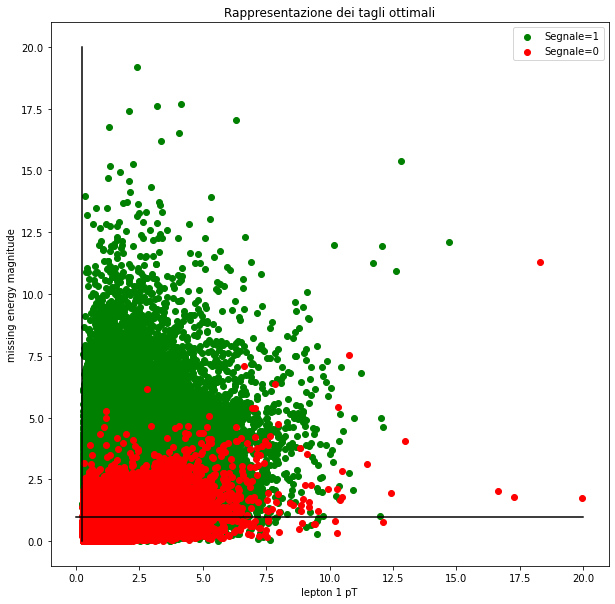

In [11]:
plt.close()
colors=['red','green']
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,title='Rappresentazione dei tagli ottimali')
for i in [1,0]:
  ax.scatter(df_train[var_1].loc[df_train['signal']==i],
          df_train[var_2].loc[df_train['signal']==i],
          marker='o',color=colors[i],label='Segnale=%d'%i)
ax.plot([cut_1_max,cut_1_max],[0,20],'black')
ax.plot([0,20],[cut_2_max,cut_2_max],'black')
ax.legend()
ax.set(xlabel=var_1,ylabel=var_2)

[Text(0.5, 0, 'Occurrence'),
 Text(0.5, 0, 'missing energy magnitude'),
 Text(0.5, 0, 'lepton 1 pT')]

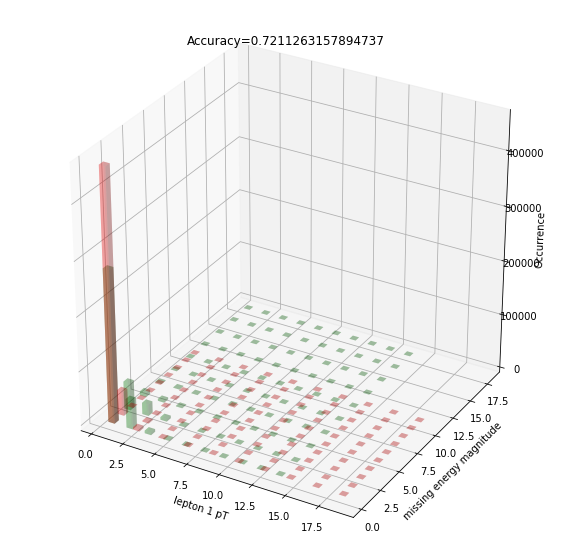

In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d',title='Accuracy='+str(acc_max))
for i in range(2):
  hist2,xedges,yedges=np.histogram2d(
      df_train[var_1].loc[df_train['signal'].values==i].values,
      df_train[var_2].loc[df_train['signal'].values==i].values)
  xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25,
                           indexing="ij")
  xpos = xpos.ravel()
  ypos = ypos.ravel()
  zpos = 0
  dx = dy = 0.5 * np.ones_like(zpos)
  dz = hist2.ravel()
  ax.bar3d(xpos,ypos,zpos,dx,dy,dz,label='Segnale=%d'%i,alpha=0.2,color=colors[i])
ax.set(xlabel=var_1,ylabel=var_2,zlabel='Occurrence')


In [13]:
# verifica su train set
var_1 = 'lepton 1 pT'
var_2 = 'missing energy magnitude'

ALL_t = df_test['signal'].count()
test_sel = df_test.loc[(df_test[var_1] >= cut_1_max) &
                       (df_test[var_2] >= cut_2_max)]
test_sel_not = df_test.loc[(df_test[var_1] < cut_1_max) | 
                           (df_test[var_2] < cut_2_max)]
TP_t = (test_sel['signal'].loc[test_sel['signal'] > 0.5]).count()
TN_t = (test_sel_not['signal'].loc[test_sel_not['signal'] < 0.5]).count()
acc_t = (TP_t + TN_t)/ALL_t
print('test sample accuracy: %f' %(acc_t))

test sample accuracy: 0.722240


***

In [0]:
#Alberi binari
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as tclf

In [0]:
# plot alberi e restituzione tagli e accuracy
def albe_plot(i,ax):
  clf=tclf(max_depth=2,max_leaf_nodes=2)
  clf=clf.fit((df_train[columns[i]].values).reshape(-1,1),df_train['signal'])
  tree.plot_tree(clf,class_names=['Segnale=0','Segnale=1'],
                 filled=True,ax=ax,label='none')
  ax.set_title(columns[i],fontsize=20)
  return([clf.tree_.threshold[0],clf.score(
      (df_train[columns[i]].values).reshape(-1,1),df_train['signal'])])

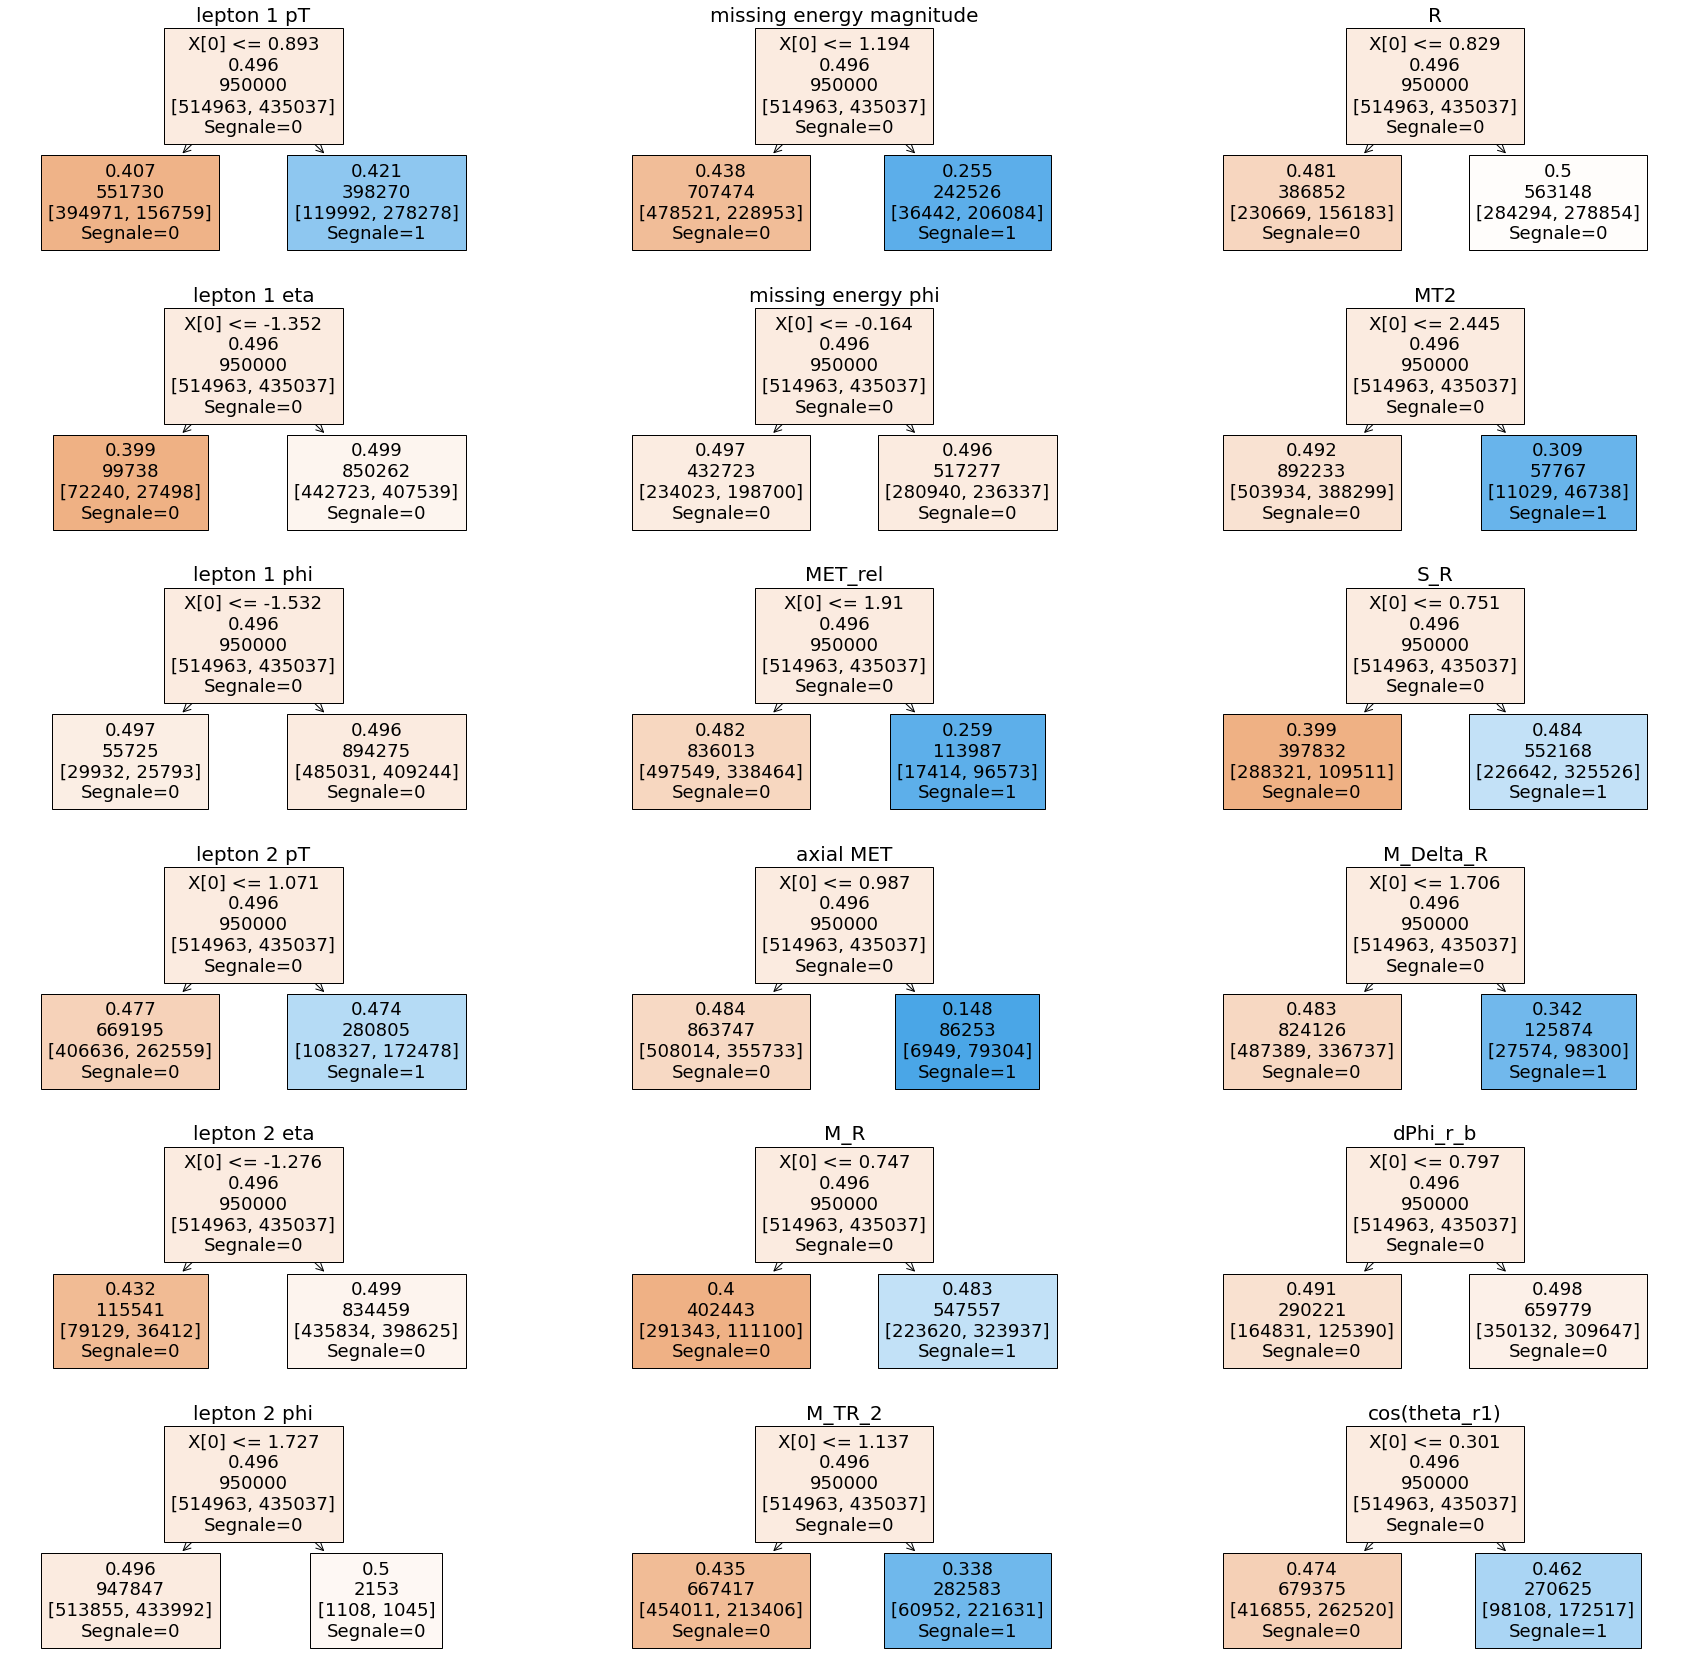

In [0]:
plt.close()
fig,axs=plt.subplots(6,3,figsize=(30,30))
acc_tree=np.zeros(len(columns)-1)
cut_tree=np.zeros(len(columns)-1)
for i in range(1,len(columns)):
  cut_tree[i-1],acc_tree[i-1]=albe_plot(i,axs[(i-1)%6,(i-1)//6])

In [0]:
pd.DataFrame({'Valore soglia':cut_tree,'Accuracy albero':acc_tree,
                    'Features':columns[1:]}
                   ).set_index('Features')

,Valore soglia,Accuracy albero
Features,,
lepton 1 pT,0.892509,0.708683
lepton 1 eta,-1.352181,0.542066
lepton 1 phi,-1.532031,0.542066
lepton 2 pT,1.071311,0.609594
lepton 2 eta,-1.275935,0.542066
lepton 2 phi,1.726755,0.542066
missing energy magnitude,1.194076,0.720637
missing energy phi,-0.164136,0.542066
MET_rel,1.910365,0.625392


Tagli effettuati a 1.194076 e 1.071069
Accuracy=0.742409


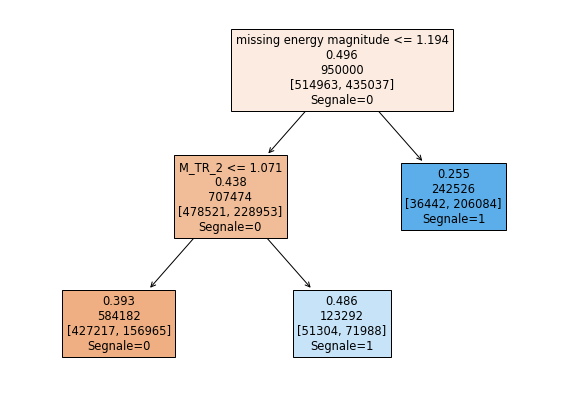

In [0]:
plt.close()
fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(1,1,1)
var_tree_1='M_TR_2'
var_tree_2='missing energy magnitude'
clf=tclf(max_depth=3,max_leaf_nodes=3)
clf=clf.fit(df_train[[var_tree_1,var_tree_2]],df_train['signal'])
tree.plot_tree(clf,feature_names=[var_tree_1,var_tree_2],
               class_names=['Segnale=0','Segnale=1'],ax=ax,label='none',filled=True)
print('Tagli effettuati a %f e %f\nAccuracy=%f'%(
          clf.tree_.threshold[0],
          clf.tree_.threshold[1],
          clf.score(df_train[[var_tree_1,var_tree_2]],df_train['signal'])
          ))

In [0]:
print('Accuracy=%.3f'%clf.score(df_test[[var_1,var_2]],df_test['signal']))

Accuracy=0.758


#### Ottimizzazzione 
Per migliorare l'efficienza dell'algoritmo si procede con una combinazione dei risultati osservati in precedenza: si procede con un taglio preliminare dei dati usando i tagli rettangolari e si normalizzano i dati in maniera gaussiana.
Scegliendo di adottare tutte e 18 le features si usa come metodo di discriminazione $L1$. <br>
Si verifica che la migliore efficienza viene raggiunta per $\alpha=3.16\ 10^{-4}$ e corrisponde a un'accuracy pari a 0.83. Come si vede il taglio combinato con la stessa dinamica dei dati ha permesso di migliorare notevolmente le prestazioni dell'algortimo, permettendo a questo di distinguere in maniera migliore tra segnale e fondo. Analizzando quindi l'istogramma del segnale e del fondo si osserva il seguente fatto: questi presentano la stessa forma. I seguenti fatti sottolineano che attraverso i tagli vengono eliminate le correlazioni banali dei dati (quelle che facevano clusterizzare da una parte e dall'alltra segnale e fondo) e che quindi l'algoritmo riesce a mettere in maggiore evidenza le correlazioni non banali dei dati, riuscendo a distinguere, sebbene presentino una probabilità simile, segnale da fondo.

In [0]:
train_sel= df_train.loc[(df_train[var_1] >= cut_1_max) &
                       (df_train[var_2] >= cut_2_max)].copy()
test_sel = df_test.loc[(df_test[var_1] >= cut_1_max) &
                       (df_test[var_2] >= cut_2_max)].copy()
train_sel[columns[1:]]=normalize(train_sel[columns[1:]].values)
test_sel[columns[1:]]=normalize(test_sel[columns[1:]].values)

Accuracy on test data with alpha 1.00E-10 : 0.779
Accuracy on test data with alpha 1.26E-09 : 0.800
Accuracy on test data with alpha 1.58E-08 : 0.747
Accuracy on test data with alpha 2.00E-07 : 0.618
Accuracy on test data with alpha 2.51E-06 : 0.830
Accuracy on test data with alpha 3.16E-05 : 0.831
Accuracy on test data with alpha 3.98E-04 : 0.831
Accuracy on test data with alpha 5.01E-03 : 0.760
Accuracy on test data with alpha 6.31E-02 : 0.744
Accuracy on test data with alpha 7.94E-01 : 0.744
Accuracy on test data with alpha 1.00E+01 : 0.744


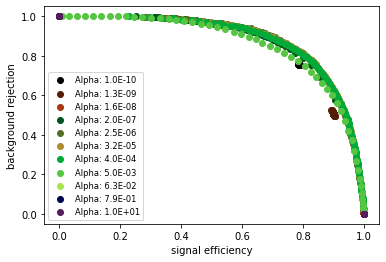

In [24]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha,train_sel,test_sel) 
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.832


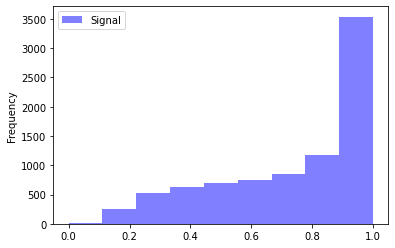

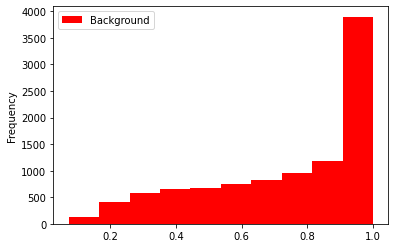

In [26]:
# grafico delle probabilità delle due classi:
plt.close()
probsSimple,accep,rej = runSciKitRegressionL1(18,3.98e-04,
                                              train_sel,test_sel)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,
                     bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')